In [1]:
%matplotlib inline

# Example of surface-based first-level analysis

A full step-by-step example of fitting a GLM to experimental data sampled on
the cortical surface and visualizing the results.

More specifically:

1. A sequence of fMRI volumes is loaded.
2. fMRI data are projected onto a reference cortical surface (the FreeSurfer
   template, fsaverage).
3. A design matrix describing all the effects related to the data is computed.
4. A GLM is applied to the dataset (effect/covariance, then contrast estimation).

The result of the analysis are statistical maps that are defined on the brain
mesh. We display them using Nilearn capabilities.

The projection of fMRI data onto a given brain mesh requires that both are
initially defined in the same space.

* The functional data should be coregistered to the anatomy from which the mesh
  was obtained.

* Another possibility, used here, is to project the normalized fMRI data to an
  MNI-coregistered mesh, such as fsaverage.

The advantage of this second approach is that it makes it easy to run
second-level analyses on the surface. On the other hand, it is obviously less
accurate than using a subject-tailored mesh.


## Prepare data and analysis parameters
Prepare the timing parameters.



In [2]:
t_r = 2.4
slice_time_ref = 0.5

Prepare the data.
First, the volume-based fMRI data.



In [3]:
from nilearn.datasets import fetch_localizer_first_level
data = fetch_localizer_first_level()
fmri_img = data.epi_img

/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /home/fnadeau/nilearn_data/localizer_first_level



Downloaded 14909440 of 34532740 bytes (43.2%,    1.3s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/fnadeau/nilearn_data/localizer_first_level/775984ff61321050eba8738c4176eda5/download..... done.


Second, the experimental paradigm.



In [4]:
events_file = data.events
import pandas as pd
events = pd.read_table(events_file)

## Project the fMRI image to the surface

For this we need to get a mesh representing the geometry of the surface. We
could use an individual mesh, but we first resort to a standard mesh, the
so-called fsaverage5 template from the FreeSurfer software.



In [5]:
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage()

The projection function simply takes the fMRI data and the mesh.
Note that those correspond spatially, are they are both in MNI space.



In [14]:
from nilearn import surface
texture = surface.vol_to_surf(fmri_img, fsaverage.pial_right)

NameError: name 'vol_to_surf' is not defined

In [15]:
texture.T.shape
help(surface.vol_to_surf)

Help on function vol_to_surf in module nilearn.surface.surface:

vol_to_surf(img, surf_mesh, radius=3.0, interpolation='linear', kind='auto', n_samples=None, mask_img=None, inner_mesh=None, depth=None)
    Extract surface data from a Nifti image.
    
    .. versionadded:: 0.4.0
    
    Parameters
    ----------
    img : Niimg-like object, 3d or 4d.
        See http://nilearn.github.io/manipulating_images/input_output.html
    
    surf_mesh : str or numpy.ndarray or Mesh
        Either a file containing surface mesh geometry (valid formats
        are .gii or Freesurfer specific files such as .orig, .pial,
        .sphere, .white, .inflated) or two Numpy arrays organized in a list,
        tuple or a namedtuple with the fields "coordinates" and "faces", or
        a Mesh object with "coordinates" and "faces" attributes.
    
    radius : float, optional
        The size (in mm) of the neighbourhood from which samples are drawn
        around each node. Ignored if `inner_mesh` is pro

## Perform first level analysis

This involves computing the design matrix and fitting the model.
We start by specifying the timing of fMRI frames.



In [16]:
import numpy as np
n_scans = texture.shape[1]
frame_times = t_r * (np.arange(n_scans) + .5)

Create the design matrix.

We specify an hrf model containing the Glover model and its time derivative
The drift model is implicitly a cosine basis with a period cutoff at 128s.



In [17]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times,
                                               events=events,
                                               hrf_model='glover + derivative'
                                               )

In [18]:
design_matrix.shape

(128, 27)

Setup and fit GLM.

Note that the output consists in 2 variables: `labels` and `fit`.
`labels` tags voxels according to noise autocorrelation.
`estimates` contains the parameter estimates.
We keep them for later contrast computation.



In [25]:
from nilearn.glm.first_level import run_glm
labels, estimates = run_glm(texture.T, design_matrix.values)
labels

array(['-0.1', '0.11', '0.14', ..., '-0.08', '0.0', '0.09'], dtype='<U5')

In [24]:
texture.T.shape, design_matrix.values.shape

((128, 10242), (128, 27))

## Estimate contrasts
Specify the contrasts.

For practical purpose, we first generate an identity matrix whose size is
the number of columns of the design matrix.



In [21]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrast_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


At first, we create basic contrasts.



In [31]:
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts

{'audio_computation': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'audio_computation_derivative': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'audio_left_hand_button_press': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'audio_left_hand_button_press_derivative': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'audio_right_hand_button_press': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'audio_right_hand_button_press_derivative': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'horizontal_checkerboard': array([0., 

Next, we add some intermediate contrasts and
one contrast adding all conditions with some auditory parts.



In [34]:
basic_contrasts['audio'] = (
    basic_contrasts['audio_left_hand_button_press']
    + basic_contrasts['audio_right_hand_button_press']
    + basic_contrasts['audio_computation']
    + basic_contrasts['sentence_listening'])

# one contrast adding all conditions involving instructions reading
basic_contrasts['visual'] = (
    basic_contrasts['visual_left_hand_button_press']
    + basic_contrasts['visual_right_hand_button_press']
    + basic_contrasts['visual_computation']
    + basic_contrasts['sentence_reading'])

# one contrast adding all conditions involving computation
basic_contrasts['computation'] = (basic_contrasts['visual_computation']
                                  + basic_contrasts['audio_computation'])

# one contrast adding all conditions involving sentences
basic_contrasts['sentences'] = (basic_contrasts['sentence_listening']
                                + basic_contrasts['sentence_reading'])

Finally, we create a dictionary of more relevant contrasts

* 'left - right button press': probes motor activity in left versus right button presses.
* 'audio - visual': probes the difference of activity between listening to some content or reading the same type of content (instructions, stories).
* 'computation - sentences': looks at the activity when performing a mental computation task  versus simply reading sentences.

Of course, we could define other contrasts, but we keep only 3 for simplicity.



In [35]:
contrasts = {
    'left - right button press': (
        basic_contrasts['audio_left_hand_button_press']
        - basic_contrasts['audio_right_hand_button_press']
        + basic_contrasts['visual_left_hand_button_press']
        - basic_contrasts['visual_right_hand_button_press']
    ),
    'audio - visual': basic_contrasts['audio'] - basic_contrasts['visual'],
    'computation - sentences': (basic_contrasts['computation'] -
                                basic_contrasts['sentences']
    )
}

Let's estimate the contrasts by iterating over them.



  Contrast  1 out of 3: left - right button press, right hemisphere
  Contrast  2 out of 3: audio - visual, right hemisphere
  Contrast  3 out of 3: computation - sentences, right hemisphere


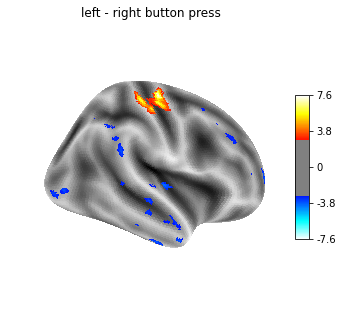

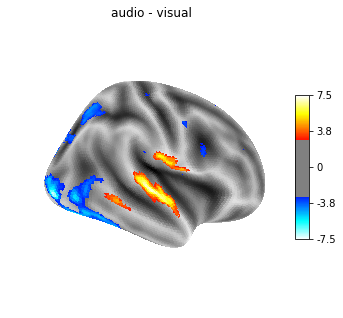

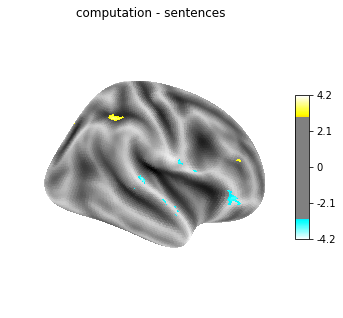

In [36]:
from nilearn.glm.contrasts import compute_contrast
from nilearn import plotting

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, right hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    plotting.plot_surf_stat_map(
        fsaverage.infl_right, z_score, hemi='right',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_right)

## Analysing the left hemisphere

Note that re-creating the above analysis for the left hemisphere requires
little additional code!



We project the fMRI data to the mesh.



In [37]:
texture = surface.vol_to_surf(fmri_img, fsaverage.pial_left)

Then we estimate the General Linear Model.



In [38]:
labels, estimates = run_glm(texture.T, design_matrix.values)

Finally, we create contrast-specific maps and plot them.



In [47]:
from nilearn.glm.contrasts import compute_contrast
from nilearn import plotting

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, right hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    plotting.plot_surf_stat_map(
        fsaverage.infl_right, z_score, hemi='right',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_right)


{'effect': array([[-408.45586953, -169.23254886, -158.19317398, ..., -118.40707994,
         -86.61766697,  -50.2885427 ]]), 'variance': array([12411.09874095,  6888.00569058,  5038.17339299, ...,
        3894.69603869,  3879.87947436,  3835.54484057]), 'dof': 101.0, 'dim': 1, 'contrast_type': 't', 'stat_': array([-3.66640153, -2.03909353, -2.2286978 , ..., -1.89732132,
       -1.39058444, -0.81199904]), 'p_value_': array([0.99980279, 0.97797368, 0.98597482, ..., 0.9696791 , 0.91629603,
       0.79064908]), 'one_minus_pvalue_': array([1.97206041e-04, 2.20263221e-02, 1.40251833e-02, ...,
       3.03208962e-02, 8.37039741e-02, 2.09350920e-01]), 'baseline': 0.0, 'tiny': 1e-50, 'dofmax': 10000000000.0, 'z_score_': array([-3.54379481, -2.01358955, -2.19658125, ..., -1.87609823,
       -1.38058061, -0.80867547])}


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
-408.4558695275897